In [1]:
%reload_ext autoreload

%autoreload 2
import numpy as np
from models import lstm
from models import stacked_lstm
import torch

In [2]:
# FILES TO CHANGE (This is where your sequence_nlp_harvey.zip etc is) 

NPY_INPUT_DIR = '/Users/ianmagnusson/IITUDND/data/extracted_features/combined_NLP/harvey/'

In [3]:
# load data from files

X_seq_tfidf_train = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_train.npz')
X_seq_tfidf_test = np.load(NPY_INPUT_DIR + 'X_seq_tfidf_test.npz')


X_seq_glove_train = np.load(NPY_INPUT_DIR + 'X_seq_glove_train.npz')
X_seq_glove_test = np.load(NPY_INPUT_DIR + 'X_seq_glove_test.npz')

y_train = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_train.npy'))
y_test = torch.Tensor(np.load(NPY_INPUT_DIR + 'y_test.npy'))

In [4]:
# format npz objects as lists of arrays again
X_tfidf_train = [ torch.Tensor(X_seq_tfidf_train[file]) for file in X_seq_tfidf_train.files]
X_tfidf_test = [ torch.Tensor(X_seq_tfidf_test[file]) for file in X_seq_tfidf_test.files]

X_glove_train = [ torch.Tensor(X_seq_glove_train[file]) for file in X_seq_glove_train.files]
X_glove_test = [ torch.Tensor(X_seq_glove_test[file]) for file in X_seq_glove_test.files]

In [5]:
# build lists with features concatenated

from sklearn.preprocessing import StandardScaler

X_raw_train = []
for i in range(len(y_train)):
    file = X_seq_tfidf_train.files[i]
    X_raw_train.append(np.concatenate((X_seq_tfidf_train[file], X_seq_glove_train[file]), axis=1))

scaler = StandardScaler()
X_fit_train = np.concatenate(X_raw_train)
scaler.fit(X_fit_train)

X_train = [torch.Tensor(scaler.transform(X_i)) for X_i in X_raw_train]

X_test = []
for i in range(len(y_test)):
    file = X_seq_tfidf_test.files[i]
    X_test.append(torch.Tensor(scaler.transform(np.concatenate((X_seq_tfidf_test[file], X_seq_glove_test[file]), axis=1))))


In [6]:
# build and train model

model = lstm.LSTM(input_dim=400, hidden_dim=200, num_layers=2, bidirectional=True, learning_rate=0.01)

model.learn(X_train, y_train)
#torch.save(model.state_dict(), 'norm_harvey_lstm.pt')

#model.load_state_dict(torch.load('norm_harvey_lstm.pt'))
#model.eval()


epoch: 0 learning rate: [0.01]
[1,   200] loss: 0.502
[1,   400] loss: 0.479
[1,   600] loss: 0.380
[1,   800] loss: 0.463
[1,  1000] loss: 0.383
[1,  1200] loss: 0.421
[1,  1400] loss: 0.397
[1,  1600] loss: 0.424
[1,  1800] loss: 0.428
[1,  2000] loss: 0.356
[1,  2200] loss: 0.451
[1,  2400] loss: 0.392
[1,  2600] loss: 0.457
[1,  2800] loss: 0.275
[1,  3000] loss: 0.389
[1,  3200] loss: 0.337
epoch: 1 learning rate: [0.005]
[2,   200] loss: 0.288
[2,   400] loss: 0.285
[2,   600] loss: 0.214
[2,   800] loss: 0.274
[2,  1000] loss: 0.300
[2,  1200] loss: 0.250
[2,  1400] loss: 0.271
[2,  1600] loss: 0.290
[2,  1800] loss: 0.281
[2,  2000] loss: 0.196
[2,  2200] loss: 0.245
[2,  2400] loss: 0.280
[2,  2600] loss: 0.246
[2,  2800] loss: 0.283
[2,  3000] loss: 0.274
[2,  3200] loss: 0.315
epoch: 2 learning rate: [0.0025]
[3,   200] loss: 0.199
[3,   400] loss: 0.174
[3,   600] loss: 0.103
[3,   800] loss: 0.115
[3,  1000] loss: 0.131
[3,  1200] loss: 0.162
[3,  1400] loss: 0.165
[3,  16

In [7]:
# evaluate
model.get_accuracy(X_test, y_test)

0.83375

R2 score for bin 0 = 0.10645994832041361
R2 score for bin 1 = 0.015997901914503232
R2 score for bin 2 = -0.06914893617021267
R2 score for bin 3 = 0.3165316531653166
R2 score for bin 4 = -0.2193486590038316
R2 score for bin 5 = 0.26277056277056265
True proportion of + scores in bin 0 = 0.6766917293233082
True proportion of + scores in bin 1 = 0.6940298507462687
True proportion of + scores in bin 2 = 0.7014925373134329
True proportion of + scores in bin 3 = 0.753731343283582
True proportion of + scores in bin 4 = 0.8656716417910447
True proportion of + scores in bin 5 = 0.8396946564885496


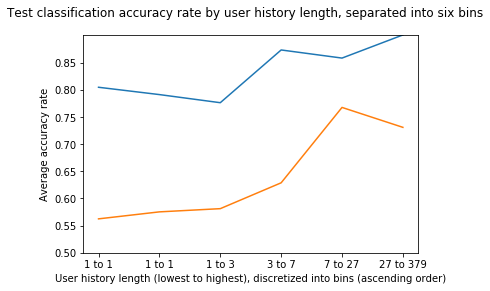

[0.8045112781954887,
 0.7910447761194029,
 0.7761194029850746,
 0.8731343283582089,
 0.8582089552238806,
 0.9007633587786259]

In [8]:
model.get_accuracy_graph(X_test, y_test)

In [9]:
model.get_auc(X_test, y_test)


0.8194857413163941